# Coordinates Of Motherboard Holes

In [1]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 8, 8

def imshow(image):
    cv2.imshow("Image", image)
    cv2.waitKey()
    cv2.destroyAllWindows()

def imshow_plt(image):
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
def imshow_plt_gray(image):
    plt.axis("off")
    plt.imshow(image, cmap = 'gray')
    
def resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    (h, w) = image.shape[:2]
    if width is None and height is None: 
        return image
    if width is None:
        ratio = height / float(h)
        dim = (int(w*ratio), height)
    else:
        ratio = width / float(w)
        dim = (width, int(h*ratio))
    resized = cv2.resize(image, dim, interpolation = inter)
    return resized

## Camera calibration

In [2]:
width, height = 22.5, 22.5 # Chessboard cell dimensions
m, n = 6, 9 # Amount of corners

# 3D points coordinates
# (0, 0, 0), (0, 22.5, 0), (0, 45, 0), … , (112.5, 157.5, 0), (112.5, 180, 0)
objp = np.zeros((m*n, 3), np.float32)
for i in range(m*n):
    objp[i][0] = (i%m)*height
    objp[i][1] = (i//m)*width
    objp[i][2] = 0
    
# Arrays with 3D and 2D points coordinates for each image
objpoints = []
imgpoints = []

In [3]:
%%time
images = glob.glob('Chessboard/*.jpg')
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
for fname in images:
    image = cv2.imread(fname)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Corners detection
    ret, corners = cv2.findChessboardCorners(gray, (m, n), None)
    if ret == True:
        # Refines the corner locations
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        objpoints.append(objp)
        imgpoints.append(corners2)
        #cv2.drawChessboardCorners(image, (m, n), corners2, ret)
        #imshow(image)

Wall time: 17.1 s


In [4]:
%%time
# Estimate camera matrix, distortion coefficients, rotation and translation vectors
_, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

Wall time: 2.44 s


In [5]:
print('Camera matrix:\n', mtx, '\n\nDistortion coefficients\n', dist)

Camera matrix:
 [[2.56249977e+03 0.00000000e+00 1.81638741e+03]
 [0.00000000e+00 2.54660355e+03 1.28322884e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 

Distortion coefficients
 [[-0.02976232 -0.03022033 -0.0057158  -0.0010025   0.00886555]]


#### Error

In [6]:
mean_error = 0
for i in np.arange(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
print("Total error: {}".format(mean_error/len(objpoints)))

Total error: 0.5476608234684816


#### Undistortion

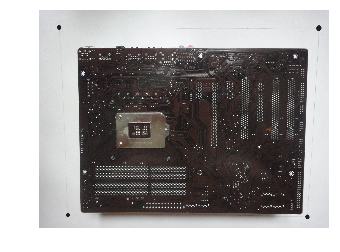

In [7]:
image = cv2.imread('Motherboard/Motherboard.jpg')
# Compute new camera matrix based on the free scaling parameter
h,  w = image.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 0)
# Image undistortion
image = cv2.undistort(image, mtx, dist, None, newcameramtx)
x, y, w, h = roi
image = image[y:y+h, x:x+w]
cv2.imwrite('Motherboard/Motherboard_undistorted.jpg', image)
imshow_plt(image)

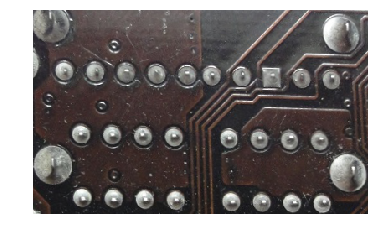

In [8]:
image = cv2.imread('Motherboard/Holes.jpg') # Audio-connector holes
h,  w = image.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 0)
image = cv2.undistort(image, mtx, dist, None, newcameramtx)
x, y, w, h = roi
image = image[y:y+h, x:x+w]
cv2.imwrite('Motherboard/Holes_undistorted.jpg', image)
imshow_plt(image)

## Searching for defining points using Hough Circles

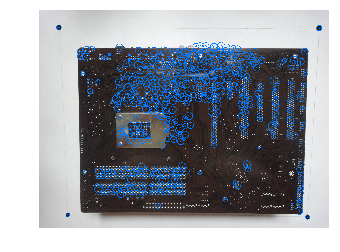

In [9]:
image = cv2.imread('Motherboard/Motherboard_undistorted.jpg')
h, w = image.shape[:2]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Circle detection
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 3.5, 50, minRadius=10, maxRadius=50)
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        # Draw the outer circle
        cv2.circle(image, (x, y), r, (255, 120, 0), 5)
        # Draw the center of the circle
        cv2.circle(image, (x, y), 5, (255, 120, 0), 5)
imshow_plt(image)

In [10]:
def find_def_points(circles, pts):
    for (x, y, r) in circles:
        if x + y < pts[0, 0] + pts[0, 1]:
            pts[0, 0], pts[0, 1] = x, y
        if x + y > pts[2, 0] + pts[2, 1]:
            pts[2, 0], pts[2, 1] = x, y
        if x - y > def_points[1, 0] - def_points[1, 1]:
            pts[1, 0], pts[1, 1] = x, y
        if x - y < pts[3, 0] - pts[3, 1]:
            pts[3, 0],  pts[3, 1] = x, y 
    return pts

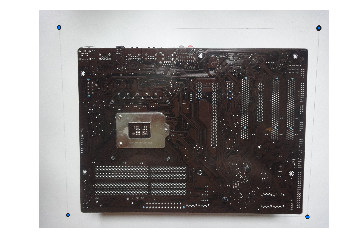

In [11]:
# Defining points detection
image = cv2.imread('Motherboard/Motherboard_undistorted.jpg')
def_points = np.array([[w, h], [0, h], [0, 0], [w, 0]])
if circles is not None:
    def_points = find_def_points(circles, def_points)
    for (x, y) in def_points:  
        # Draw defining points
        cv2.rectangle(image, (x - 15, y - 15), (x + 15, y + 15), (255, 120, 0), -1)
imshow_plt(image)  

In [12]:
print('Defining poins:\n', def_points)

Defining poins:
 [[ 250  219]
 [3523  226]
 [3379 2599]
 [ 362 2571]]


## Locate motherboard contour using Canny

In [13]:
# Edge detection using Red, Green and Blue images
def CannyBGR(image, T1, T2):
    image = cv2.GaussianBlur(image, (5, 5), 0)
    (B, G, R) = cv2.split(image)
    B = cv2.Canny(B, T1, T2)
    G = cv2.Canny(G, T1, T2)
    R = cv2.Canny(R, T1, T2)
    canny = cv2.bitwise_or(cv2.bitwise_or(B, G), R)
    return canny

#### Edge detection

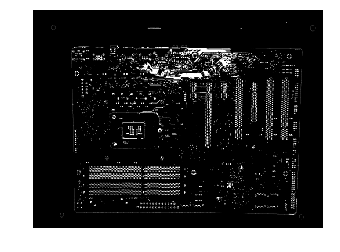

In [14]:
image = cv2.imread('Motherboard/Motherboard_undistorted.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
canny = CannyBGR(image, 50, 120)

kernel = np.ones((5,5),np.uint8)
canny = cv2.dilate(canny, kernel, iterations = 1)
canny = cv2.erode(canny, kernel, iterations = 1)

imshow_plt_gray(resize(canny, width = 500))

#### Find contour

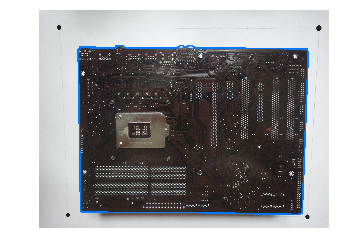

In [15]:
cnts = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[1]
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)
cnt = cnts[0]
curveLength = cv2.arcLength(cnt, True)
eps = 0.001*curveLength # max distance from the initial to the approximated contour
approx = cv2.approxPolyDP(cnt, eps, True) # aprroximated contour with fewer vertices
cv2.drawContours(image, [approx], -1, (255, 120, 0), 20)
imshow_plt(image)

#### ROI

True

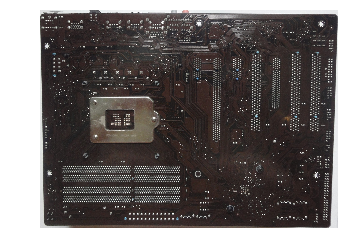

In [16]:
image = cv2.imread('Motherboard/Motherboard_undistorted.jpg')
max_y, max_x  = 0, 0 
min_y, min_x = image.shape[:2]
for [(x, y)] in cnt:
    if x < min_x: min_x = x
    if x > max_x: max_x = x
    if y < min_y: min_y = y
    if y > max_y: max_y = y
imshow_plt(image[min_y:max_y, min_x:max_x])
cv2.imwrite('Motherboard/Motherboard_roi.jpg', image[min_y:max_y, min_x:max_x])

## Features detection using SURF

In [17]:
img1 = cv2.imread('Motherboard/Holes.jpg')
img2 = cv2.imread('Motherboard/Motherboard_roi.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Feature Detection and Description
surf = cv2.xfeatures2d.SURF_create(300)
kp1, des1 = surf.detectAndCompute(img1, None)
kp2, des2 = surf.detectAndCompute(img2, None)

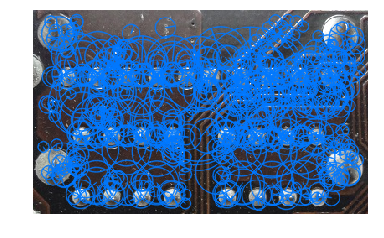

In [18]:
image = cv2.imread('Motherboard/Holes.jpg')
image = cv2.drawKeypoints(image, kp1, None, (255, 120, 0), 4)
imshow_plt(image)

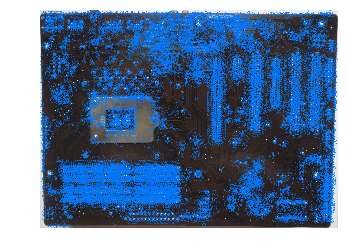

In [19]:
image = cv2.imread('Motherboard/Motherboard_roi.jpg')
image = cv2.drawKeypoints(image, kp2, None, (255, 120, 0), 4)
imshow_plt(image)

Matches are found - 286


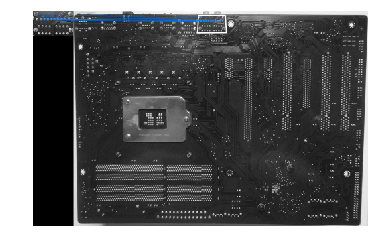

In [20]:
MIN_MATCH_COUNT = 10 # Minimum number of matching features
# Matcher parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
# Two best coincidence of points
matches = flann.knnMatch(des1, des2, k=2)
good = []
for m, n in matches:
    if m.distance < 0.95*n.distance:
        good.append(m)

# Searching for area with holes for Audio-connector on the motherboard image     
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    h, w = img1.shape
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)
    #img1 = cv2.drawKeypoints(img1, kp1, None, (255, 120, 0), 4)
    #img2 = cv2.drawKeypoints(img2, kp2, None, (255, 120, 0), 4)
    img2 = cv2.polylines(img2, [np.int32(dst)], True, (255, 255, 255), 10, cv2.LINE_AA)
    print("Matches are found - {}".format(len(good)))
else:
    print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
    matchesMask = None
    
# Draw lines between features
draw_params = dict(matchColor = (255, 120, 0), singlePointColor = None, 
                   matchesMask = matchesMask, flags = 2)
img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)
imshow_plt(resize(img3, width = 500))

In [21]:
print("Coordinates of area with holes for Audio-connector:\n", np.int32(dst))

Coordinates of area with holes for Audio-connector:
 [[[1232   44]]

 [[1223  217]]

 [[1507  215]]

 [[1495   43]]]


Coordinates of center:  1848 574


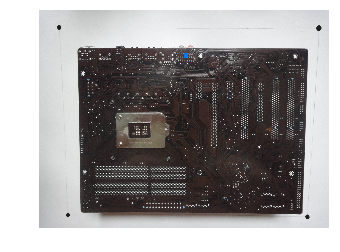

In [22]:
# Coordinates of center of this area
M = cv2.moments(np.int32(dst))
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
cx = cx + min_x
cy = cy + min_y
print("Coordinates of center: ", cx, cy)
image = cv2.imread('Motherboard/motherboard_undistorted.jpg')
cv2.rectangle(image, (cx - 30, cy - 30), (cx + 30, cy + 30), (255, 120, 0), -1)
imshow_plt(image)

## Compute matrix of extrinsic parameters

In [23]:
# Coordinates of defining points on the image
imgpoints = def_points.reshape(4, 2, 1).astype("float64")
# Coordinates of defining points in real world
objpoints = np.array([[0, 300, 0], [400, 300, 0], [400, 0, 0], [0, 0, 0]], dtype="float64").reshape(4, 3, 1)
# Compute rotation matrix and translation vector
_, rvec, t = cv2.solvePnP(objpoints, imgpoints, mtx, None)
R, _ = cv2.Rodrigues(rvec)
print("R: \n", R, "\n\nt: \n", t)

R: 
 [[ 0.99995803  0.00463844 -0.00790056]
 [ 0.00527689 -0.99655155  0.082808  ]
 [-0.00748921 -0.08284622 -0.9965342 ]] 

t: 
 [[-193.7929937 ]
 [ 169.41947667]
 [ 338.394141  ]]


## Compute point coordinates in real world

### $sm = A[R|t]M$

In [24]:
def objectPoints(m, A, R, t):
    return np.dot(np.linalg.inv(R), np.dot(np.linalg.inv(A), m) - t)

In [25]:
# Point coordinates on the image
m = np.array([cx, cy, 1], dtype = "float64")
print(m)

[1.848e+03 5.740e+02 1.000e+00]


In [26]:
# Point coordinates in real world
h = 50 # z-coordinate of the holes
s = h*R[2, 2] + t[2] # Initial value
eps = 0.01

M = objectPoints(s*m, mtx, R, t.reshape(3, ))
while not (h - eps < M[2] < h + eps):
    s += (M[2] - h)*eps
    M = objectPoints(s*m, mtx, R, t.reshape(3, ))
    
print(M)

[196.32494578 249.65503291  49.99005293]
